In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports

In [2]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 47.0 MB/s eta 0:00:0000:0100:01


In [16]:
!pip install --upgrade accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Using cached accelerate-0.19.0-py3-none-any.whl (219 kB)


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import evaluate
import torch.nn as nn
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForTokenClassification, DataCollatorForTokenClassification
import torch.optim as optim
import datasets
from datasets import load_dataset
from datasets import load_dataset_builder
from datasets import Dataset
from sklearn import preprocessing
import copy
from datasets import load_dataset
path = '/kaggle/input/factrueval2016/'
seqeval = evaluate.load("seqeval")
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import tqdm
tqdmn = tqdm.notebook.tqdm

model_name = "Babelscape/wikineural-multilingual-ner"
n_epochs = 4
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import Tokenizer

In [26]:
dir = '../input/factrueval2016/'
train_f = f'{dir}train.txt'
dev_f = f'{dir}dev.txt'
test_f = f'{dir}test.txt'

label2id = {'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

id2label={0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-MISC',
 8: 'I-MISC'}
with open(train_f,'r') as train:
    train_words = train.readlines()
with open(dev_f,'r') as dev:
    dev_words = dev.readlines()
with open(test_f,'r') as test:
    test_words = test.readlines() 

# Import data

In [27]:
def get_tokens_ners(words):
    # 
    # read text
    tokens, ner_tags = [],[]
    for word in words:
        if len(word.strip())>0:
            #print(word)
            token, ner = word.split()
            ner = ner.strip('\n')
            tokens.append(token)
            ner_tags.append(ner)
    return tokens, ner_tags

In [28]:
ex_1 = ' '.join(get_tokens_ners(test_words)[0])
ex_1[:500]

'" Если Миронов занял столь оппозиционную позицию , то мне представляется , что для него было бы порядочным и правильным уйти в отставку с занимаемого им поста , поста , который предоставлен ему сегодня " Единой Россией \'\' и никем больше \'\' , - заключает Исаев . Источник " Ъ \'\' в руководстве столичной мэрии считает маловероятным , что господина Митволя назначили с целью " укрепления границ с Подмосковьем \'\' . В Ханты-Мансийском автономном округе с должности снят начальник УВД Николай Гудожников .'

In [30]:
ex_2 = ' '.join(get_tokens_ners(test_words)[0])
ex_2[:500]

"Тогда замешанные в скандале прокуроры отделались выговорами и благополучно вернулись на работу . Символичным назвал председатель РФМ , депутат Государственной думы РФ Леонид Слуцкий ( ЛДПР ) установку памятника Твардовскому в день годовщины Великой Отечественной войны . На посту гендиректора Yahoo ! B-ORG Кэрол Бартц сменила Джерри Янга - основателя компании . Считаю невозможным руководить областью с таким уровнем доверия населения '' , - сообщил тогда сам В.Позгалев . Боксер победила Карли Фиор"

In [31]:
dataset = load_dataset("conll2003")
dataset['train'][0]

Generating train split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3251 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3454 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [33]:
def get_dict_tokens_ners(words):
    

    idx, tokens, ner_tags  = 0, [],[]
    dataset_json = []
    for line in words:

        line = line.strip('\n')
        if len(line.strip()) == 0:

            cur_tokens = copy.deepcopy(tokens)
            cur_ner_tags =copy.deepcopy(ner_tags)

            dict_ner = {'id': idx, 'tokens': cur_tokens,'length': len(cur_tokens), 'ner_tags_str': cur_ner_tags, 'ner_tags': [ label2id[i] for i in cur_ner_tags]}
            dataset_json.append(dict_ner)

            idx += 1
            tokens.clear()
            ner_tags.clear()
        else:
            token, ner = line.split()

            # check if ner tag not in token
            if token not in list(id2label.keys()):
                ner = ner.strip('\n')
                tokens.append(token)
                ner_tags.append(ner)
    data = {}
    data['data'] = dataset_json      
    return data

In [34]:
%%time
import json

names = ['train', 'dev', 'test']
for idx, words in enumerate([train_words, dev_words, test_words]):
    print(names[idx])
    data = get_dict_tokens_ners(words)
    with open(f'{names[idx]}_data.json', 'w') as f:
        json.dump(data, f)

train
dev
test
CPU times: user 2.01 s, sys: 27.7 ms, total: 2.03 s
Wall time: 2.03 s


In [35]:
tokens, ner_tags = [],[]
for word in words:
    if len(word.strip())>0:
        #print(word)
        token, ner = word.split()
        ner = ner.strip('\n')
        tokens.append(token)
        ner_tags.append(ner)
        
text = ' '.join(tokens)

In [37]:
data_files = {"train": 'train_data.json', 'val':'dev_data.json', 'test':'test_data.json'}
load_json_dataset = load_dataset('json', data_files=data_files,field ='data')
load_json_dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-d885fc5a3d4f683a/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'length', 'ner_tags_str', 'ner_tags'],
        num_rows: 7746
    })
    val: Dataset({
        features: ['id', 'tokens', 'length', 'ner_tags_str', 'ner_tags'],
        num_rows: 2582
    })
    test: Dataset({
        features: ['id', 'tokens', 'length', 'ner_tags_str', 'ner_tags'],
        num_rows: 2582
    })
})

In [38]:
MAX_LEN = max([max(load_json_dataset['train']['length']), max(load_json_dataset['val']['length']), max(load_json_dataset['test']['length'])])
MAX_LEN

222

In [39]:
num_labels = dataset['train'].features['ner_tags'].feature.num_classes

## Metadata

К исходным данным добавим методанные

In [40]:
print(dataset['train'].description)
print(dataset['train'].citation)
print(dataset['train'].homepage)
print(dataset['train'].license)

The shared task of CoNLL-2003 concerns language-independent named entity recognition. We will concentrate on
four types of named entities: persons, locations, organizations and names of miscellaneous entities that do
not belong to the previous three groups.

The CoNLL-2003 shared task data files contain four columns separated by a single space. Each word has been put on
a separate line and there is an empty line after each sentence. The first item on each line is a word, the second
a part-of-speech (POS) tag, the third a syntactic chunk tag and the fourth the named entity tag. The chunk tags
and the named entity tags have the format I-TYPE which means that the word is inside a phrase of type TYPE. Only
if two phrases of the same type immediately follow each other, the first word of the second phrase will have tag
B-TYPE to show that it starts a new phrase. A word with tag O is not part of a phrase. Note the dataset uses IOB2
tagging scheme, whereas the original dataset uses IOB1.

For 

# Preprocessing

In [41]:
def add_encodings(example):
    """Processing the example
    
    Args:
        example (dict): The dataset example.
    
    Returns:
        dict: The dictionary containing the following updates:
            - input_ids: The list of input ids of the tokens.
            - attention_mask: The attention mask list.
            - ner_tags: The updated ner_tags.
    
    """

    try:
        encodings = tokenizer(example['tokens'], truncation=True, padding='max_length',max_length=MAX_LEN, is_split_into_words=True)
        labels = example['ner_tags'] + [0] * (MAX_LEN - len(example['ner_tags']))
        return { **encodings, 'labels': labels }
    except Exception as ex:
        print(ex)
        
        return 

In [42]:
load_json_dataset = load_json_dataset.map(add_encodings)

  0%|          | 0/7746 [00:00<?, ?ex/s]

  0%|          | 0/2582 [00:00<?, ?ex/s]

  0%|          | 0/2582 [00:00<?, ?ex/s]

In [43]:
load_json_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Model

In [44]:
model = AutoModelForTokenClassification.from_pretrained(model_name , num_labels=num_labels)
# assign the 'id2label' and 'label2id' model configs
model.config.id2label = id2label
model.config.label2id = label2id

In [45]:
model.train().to(device)
# initialize the Adam optimizer (used for training/updating the model)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)

In [46]:
train_data = torch.utils.data.DataLoader(load_json_dataset['train'], batch_size=16)

In [47]:
train_loss = []
for epoch in tqdmn(range(n_epochs)):
    current_loss = 0
    for i, batch in enumerate(tqdmn(train_data)):
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model(**batch)
        loss = outputs[0]
        loss.backward()
        current_loss += loss.item()
        if i % 8 == 0 and i > 0:
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(current_loss / 32)
            current_loss = 0
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

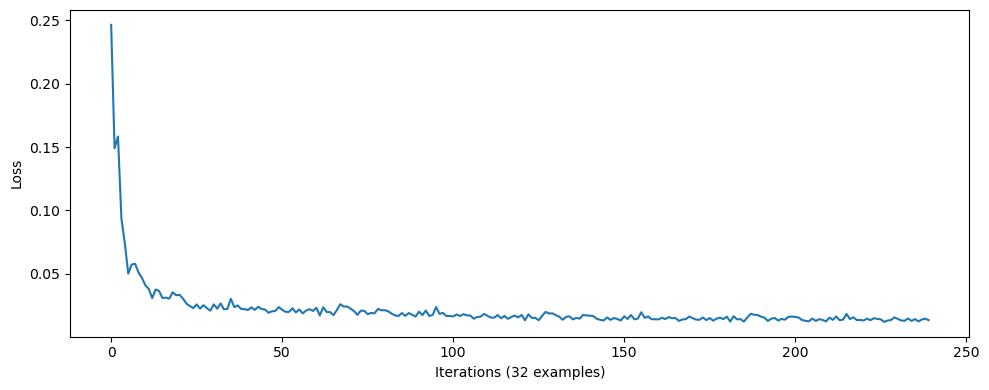

In [48]:
fig, ax = plt.subplots(figsize=(10, 4))
# visualize the loss values
ax.plot(train_loss)
# set the labels
ax.set_ylabel('Loss')
ax.set_xlabel('Iterations (32 examples)')
fig.tight_layout()
plt.show()